<a href="https://colab.research.google.com/github/BankNatchapol/CV-QNN/blob/main/Pennylane_CVQNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installation**

In [ ]:
!pip install pennylane-sf

# **Import Library**

In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, QNGOptimizer

import matplotlib.pyplot as plt 
import pandas as pd

import tensorflow as tf
import math

# **Continuous Variable Quantum Neural Network : Function Fitting**

## Load Data

In [ ]:
def tanh_function(x, eps=0.0):
    """The function f(x)=tanh(4x)+noise"""
    return np.tanh(4*x) + eps * np.random.normal(size=x.shape)

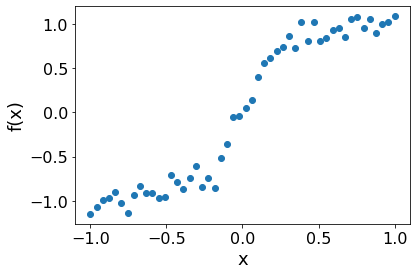

In [ ]:
X = np.linspace(-1, 1, 50)
Y = tanh_function(X, 0.1)

plt.figure()
plt.scatter(X, Y)
plt.xlabel("x", fontsize=18)
plt.ylabel("f(x)", fontsize=18)
plt.tick_params(axis="both", which="major", labelsize=16)
plt.tick_params(axis="both", which="minor", labelsize=16)
plt.show()

## Define Device

using strawberryfields.fork device for returning continuous variable quantum fork state

In [ ]:
dev = qml.device("strawberryfields.fock", wires=1, cutoff_dim=10)

## Define Continuous Variable Quantum Neural Network
### Quantum Layer
<img src="https://github.com/BankNatchapol/CV-QNN/blob/main/static/single-qubit-quantum-layer.png?raw=true">

In [ ]:
def layer(v):
    # Matrix multiplication of input layer
    qml.Rotation(v[0], wires=0)
    qml.Squeezing(v[1], 0.0, wires=0)
    qml.Rotation(v[2], wires=0)

    # Bias
    qml.Displacement(v[3], 0.0, wires=0)

    # Element-wise nonlinear transformation
    qml.Kerr(v[4], wires=0)

### Combining Quantum Layer into Quantum Neural Network
<img src="https://github.com/BankNatchapol/CV-QNN/blob/main/static/single-qubit-quantum-neural-network.png?raw=true">

In [ ]:
@qml.qnode(dev)
def quantum_neural_net(var, x):
    # Encode input x into quantum state
    qml.Displacement(x, 0.0, wires=0)

    # "layer" subcircuits
    for v in var:
        layer(v)

    return qml.expval(qml.X(0))

### Cost Function

using Mean Square Error

<img src="https://miro.medium.com/max/1400/0*oxg81Sl5QDauFysz">

In [ ]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In [ ]:
def cost(var, features, labels):
    preds = [quantum_neural_net(var, x) for x in features]
    return square_loss(labels, preds)

## Parameters Initialization
4x5 Matrix of 4 layers 5 gate QNN

In [ ]:
np.random.seed(0)
num_layers = 4
var_init = 0.05 * np.random.randn(num_layers, 5)
print(var_init)

[[ 0.08820262  0.02000786  0.0489369   0.11204466  0.0933779 ]
 [-0.04886389  0.04750442 -0.00756786 -0.00516094  0.02052993]
 [ 0.00720218  0.07271368  0.03805189  0.00608375  0.02219316]
 [ 0.01668372  0.07470395 -0.01025791  0.01565339 -0.04270479]]


## Training QNN

In [ ]:
opt = AdamOptimizer(0.01)

loss_plot = []

var = var_init
for it in range(100):
    var, _cost = opt.step_and_cost(lambda v: cost(v, X, Y), var)
    loss_plot.append(_cost)
    print("Iter: {:5d} | Cost: {:0.7f} ".format(it, _cost))

Iter:     0 | Cost: 0.1132256 
Iter:     1 | Cost: 0.0951169 
Iter:     2 | Cost: 0.0840686 
Iter:     3 | Cost: 0.0764727 
Iter:     4 | Cost: 0.0711412 
Iter:     5 | Cost: 0.0674666 
Iter:     6 | Cost: 0.0650490 
Iter:     7 | Cost: 0.0635786 
Iter:     8 | Cost: 0.0627929 
Iter:     9 | Cost: 0.0624615 
Iter:    10 | Cost: 0.0623837 
Iter:    11 | Cost: 0.0623909 
Iter:    12 | Cost: 0.0623504 
Iter:    13 | Cost: 0.0621685 
Iter:    14 | Cost: 0.0617908 
Iter:    15 | Cost: 0.0611994 
Iter:    16 | Cost: 0.0604079 
Iter:    17 | Cost: 0.0594534 
Iter:    18 | Cost: 0.0583885 
Iter:    19 | Cost: 0.0572725 
Iter:    20 | Cost: 0.0561635 
Iter:    21 | Cost: 0.0551127 
Iter:    22 | Cost: 0.0541601 
Iter:    23 | Cost: 0.0533322 
Iter:    24 | Cost: 0.0526422 
Iter:    25 | Cost: 0.0520908 
Iter:    26 | Cost: 0.0516681 
Iter:    27 | Cost: 0.0513564 
Iter:    28 | Cost: 0.0511331 
Iter:    29 | Cost: 0.0509728 
Iter:    30 | Cost: 0.0508499 
Iter:    31 | Cost: 0.0507402 
Iter:   

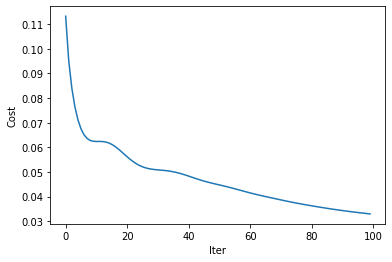

In [ ]:
plt.figure()
plt.plot(loss_plot)
plt.xlabel("Iter")
plt.ylabel("Cost")
plt.tick_params(axis="both", which="major")
plt.tick_params(axis="both", which="minor")
plt.show()

## Evaluate

In [ ]:
x_pred = np.linspace(-1, 1, 50)
predictions = [quantum_neural_net(var, x_) for x_ in x_pred]

print("Mean square error : ", cost(var, X, Y))

Mean square error :  0.032832992417139745


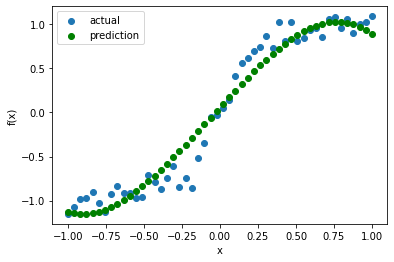

In [ ]:
plt.figure()
plt.scatter(X, Y, label= "actual")
plt.scatter(x_pred, predictions, color="green", label = "prediction")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.tick_params(axis="both", which="major")
plt.tick_params(axis="both", which="minor")
plt.legend()
plt.show()

# **Titanic - Machine Learning from Disaster**
Dataset from https://www.kaggle.com/c/titanic 

## Load Data

In [ ]:
!wget https://github.com/BankNatchapol/CV-QNN/raw/main/static/train.csv

--2021-07-22 13:41:28--  https://github.com/BankNatchapol/CV-QNN/raw/main/static/train.csv
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/BankNatchapol/CV-QNN/main/static/train.csv [following]
--2021-07-22 13:41:28--  https://raw.githubusercontent.com/BankNatchapol/CV-QNN/main/static/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60302 (59K) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]  58.89K  --.-KB/s    in 0.01s   

2021-07-22 13:41:28 (4.37 MB/s) - ‘train.csv’ saved [60302/60302]



In [ ]:
train = pd.read_csv('train.csv')
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## EDA

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Feature Extraction

In [ ]:
feature_cols = ['Age', 'Fare']
label = ['Survived']

train_data = train[feature_cols]
train_label = train[label]

In [ ]:
train_data['Age'] = train_data['Age'].fillna(train_data['Age'].mean())
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     891 non-null    float64
 1   Fare    891 non-null    float64
dtypes: float64(2)
memory usage: 14.0 KB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
train_data.head()

,Age,Fare
0,22.0,7.2500
1,38.0,71.2833
2,26.0,7.9250
3,35.0,53.1000
4,35.0,8.0500


In [ ]:
# Standard Scaler
train_data[['Age']] = (train_data[['Age']] - train_data[['Age']].min())/train_data[['Age']].max()
train_data[['Fare']] = (train_data[['Fare']] - train_data[['Fare']].min())/train_data[['Fare']].max()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
train_data.head()

,Age,Fare
0,0.26975,0.014151
1,0.46975,0.139136
2,0.31975,0.015469
3,0.43225,0.103644
4,0.43225,0.015713


## Continuous Variable Quantum Neural Network

<img src="https://github.com/BankNatchapol/CV-QNN/blob/main/static/titanic-qnn.png?raw=true">

In [ ]:
num_modes = 2

In [ ]:
dev = qml.device("strawberryfields.fock", wires=num_modes, cutoff_dim=10)

### Define Layers

In [ ]:
def Interferometer(theta, phi, varphi, wires, mesh='rectangular', beamsplitter='pennylane'):
    w = wires
    M = len(w)

    if M == 1:
        # the interferometer is a single rotation
        qml.Rotation(varphi[0], wires=w[0])
        return

    n = 0 # keep track of free parameters

    if mesh == 'rectangular':
        # Apply the Clements beamsplitter array
        # The array depth is N
        for l in range(M):
            for k, (w1, w2) in enumerate(zip(w[:-1], w[1:])):
                #skip even or odd pairs depending on layer
                if (l+k)%2 != 1:
                    if beamsplitter == 'clements':
                        qml.Rotation(phi[n], wires=[w1])
                        qml.Beamsplitter(theta[n], 0, wires=[w1, w2])
                    else:
                        qml.Beamsplitter(theta[n], phi[n], wires=[w1, w2])
                    n += 1

    elif mesh == 'triangular':
        # apply the Reck beamsplitter array
        # The array depth is 2*N-3
        for l in range(2*M-3):
            for k in range(abs(l+1-(M-1)), M-1, 2):
                if beamsplitter == 'clements':
                    qml.Rotation(phi[n], wires=[w[k]])
                    qml.Beamsplitter(theta[n], 0, wires=[w[k], w[k+1]])
                else:
                    qml.Beamsplitter(theta[n], phi[n], wires=[w[k], w[k+1]])
                n += 1

    # apply the final local phase shifts to all modes
    for i, p in enumerate(varphi):
        qml.Rotation(p, wires=[w[i]])

def layer(v):
    wires = list(range(num_modes))

    # Matrix multiplication of input layer
    if len(wires) == 1:
      s = 0
      Interferometer(None, None, v[s], wires)
    else:
      s = (num_list[num_modes-1] - 3*num_modes)//2
      Interferometer(v[0:s-num_modes+1], v[s-num_modes+1:2*(s-num_modes+1)], v[2*(s-num_modes+1):s], wires)
    for i in range(len(wires)):
      qml.Squeezing(v[s + i], 0.0, wires= i)

    n = s + len(wires)
    if len(wires) == 1:
      sl = 0
      Interferometer(None, None, v[n + sl], wires)
    else:
      sl = n+s
      Interferometer(v[n:n+s-num_modes+1], v[n+s-num_modes+1:n+2*(s-num_modes+1)], v[n+2*(s-num_modes+1):sl], wires)
    

    # Bias
    for i in range(len(wires)):
      qml.Displacement(v[sl + i], 0.0, wires= i)
    

    # Element-wise nonlinear transformation
    ken = sl + len(wires)
    for i in range(len(wires)):
      qml.Kerr(v[ken + i], wires= i)


In [ ]:
@qml.qnode(dev)
def quantum_neural_net(var, x):
    # Encode input x into quantum state
    for i in range(num_modes):
      qml.Displacement(x[i], 0.0, wires=i)

    # "layer" subcircuits
    for v in var:
        layer(v)
        
    return [qml.expval(qml.X(i)) for i in range(num_modes)]

### Parameters Initialization

In [ ]:
num_list = [5, 12, 25]
for i in range(4, 10):
  num_list.append(i*3 + (2*(num_list[-1] - (i-1)*3) - (num_list[-2] - (i-2)*3) + 4))
  

np.random.seed(0)
num_layers = 2
var_init = 0.05 * np.random.randn(num_layers, num_list[num_modes-1])
print(var_init)

[[ 0.08820262  0.02000786  0.0489369   0.11204466  0.0933779  -0.04886389
   0.04750442 -0.00756786 -0.00516094  0.02052993  0.00720218  0.07271368]
 [ 0.03805189  0.00608375  0.02219316  0.01668372  0.07470395 -0.01025791
   0.01565339 -0.04270479 -0.12764949  0.03268093  0.04322181 -0.03710825]]


### Cost Function

using Mean Square Error

<img src="https://miro.medium.com/max/1400/0*oxg81Sl5QDauFysz">

In [ ]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In [ ]:
def cost(var, features, labels):
    preds = [quantum_neural_net(var, x)[0] for x in features]
    return square_loss(labels, preds)

### Training QNN

In [ ]:
X = np.array(train_data.to_numpy())
Y = np.array(train_label.to_numpy().T[0])

opt = AdamOptimizer(0.01, beta1=0.9, beta2=0.999)

loss_plot = []

var = var_init
for it in range(100):
    var, _cost = opt.step_and_cost(lambda v: cost(v, X, Y), var)
    loss_plot.append(_cost)
    print("Iter: {:5d} | Cost: {:0.7f} ".format(it, _cost))

Iter:     0 | Cost: 0.3392135 
Iter:     1 | Cost: 0.3373101 
Iter:     2 | Cost: 0.3360096 
Iter:     3 | Cost: 0.3349394 
Iter:     4 | Cost: 0.3339723 
Iter:     5 | Cost: 0.3330457 
Iter:     6 | Cost: 0.3321256 
Iter:     7 | Cost: 0.3311931 
Iter:     8 | Cost: 0.3302394 
Iter:     9 | Cost: 0.3292618 
Iter:    10 | Cost: 0.3282612 
Iter:    11 | Cost: 0.3272405 
Iter:    12 | Cost: 0.3262029 
Iter:    13 | Cost: 0.3251510 
Iter:    14 | Cost: 0.3240857 
Iter:    15 | Cost: 0.3230063 
Iter:    16 | Cost: 0.3219098 
Iter:    17 | Cost: 0.3207919 
Iter:    18 | Cost: 0.3196465 
Iter:    19 | Cost: 0.3184668 
Iter:    20 | Cost: 0.3172457 
Iter:    21 | Cost: 0.3159762 
Iter:    22 | Cost: 0.3146520 
Iter:    23 | Cost: 0.3132676 
Iter:    24 | Cost: 0.3118188 
Iter:    25 | Cost: 0.3103022 
Iter:    26 | Cost: 0.3087157 
Iter:    27 | Cost: 0.3070578 
Iter:    28 | Cost: 0.3053276 
Iter:    29 | Cost: 0.3035245 
Iter:    30 | Cost: 0.3016482 
Iter:    31 | Cost: 0.2996983 
Iter:   

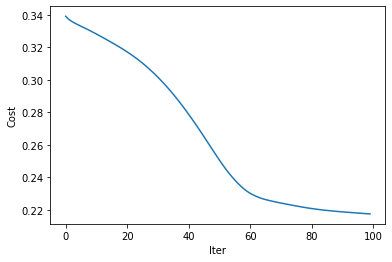

In [ ]:
plt.figure()
plt.plot(loss_plot)
plt.xlabel("Iter")
plt.ylabel("Cost")
plt.tick_params(axis="both", which="major")
plt.tick_params(axis="both", which="minor")
plt.show()

### Evaluate

In [ ]:
re = []
for i in range(len(X)):
  re.append(int(quantum_neural_net(var, X[i])[0]>0.5))

su = 0
for i in range(len(Y)):
  su += int(Y[i]==re[i])
print("Accuracy : ", su/len(Y))

Accuracy :  0.67003367003367


## Compare Continuous Variable Quantum Neural Network with Classical Neural Network 

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units = 10, activation = 'relu', input_shape = (2, )))
model.add(tf.keras.layers.Dense(units = 10, activation = 'relu'))
model.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))

model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

history = model.fit(X.reshape(-1, 2), Y, epochs =100)

Epoch 1/100
28/28 [==============================] - 1s 1ms/step - loss: 0.2407 - accuracy: 0.6296
Epoch 2/100
28/28 [==============================] - 0s 1ms/step - loss: 0.2351 - accuracy: 0.6207
Epoch 3/100
28/28 [==============================] - 0s 1ms/step - loss: 0.2326 - accuracy: 0.6207
Epoch 4/100
28/28 [==============================] - 0s 1ms/step - loss: 0.2312 - accuracy: 0.6218
Epoch 5/100
28/28 [==============================] - 0s 2ms/step - loss: 0.2303 - accuracy: 0.6207
Epoch 6/100
28/28 [==============================] - 0s 1ms/step - loss: 0.2289 - accuracy: 0.6263
Epoch 7/100
28/28 [==============================] - 0s 1ms/step - loss: 0.2279 - accuracy: 0.6251
Epoch 8/100
28/28 [==============================] - 0s 1ms/step - loss: 0.2269 - accuracy: 0.6285
Epoch 9/100
28/28 [==============================] - 0s 2ms/step - loss: 0.2261 - accuracy: 0.6285
Epoch 10/100
28/28 [==============================] - 0s 1ms/step - loss: 0.2251 - accuracy: 0.6308
Epoch 11/

In [ ]:
print("Classical NN Accuracy : ", history.history['accuracy'][-1])
print("Quantum NN Accuracy   : ", su/len(Y))


Classical NN Accuracy :  0.6992143392562866
Quantum NN Accuracy   :  0.67003367003367


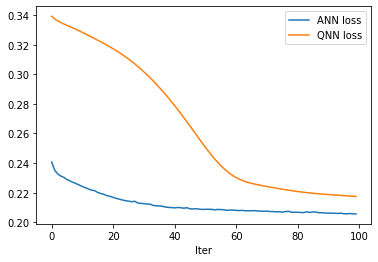

In [ ]:
plt.figure()
plt.plot(history.history['loss'], label = 'ANN loss')
plt.plot(loss_plot, label = 'QNN loss')
plt.xlabel("Iter")
plt.legend()
plt.tick_params(axis="both", which="major")
plt.tick_params(axis="both", which="minor")
plt.show()
